In [1]:
import numpy as np
from scipy.io import loadmat

import matplotlib.pyplot as plt
%matplotlib inline 

## Let's start from linear SVM 
from sklearn.svm import LinearSVC
# http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
from sklearn import svm

from tqdm import tqdm # for progressive bar

from sklearn.externals import joblib # to save model


## load one epoch data

In [4]:
def load_one_epoch(subject, data_type, epoch_num):
    if data_type is 'train':
        epoch_data=loadmat("data/{}{}-allfilt10.mat".format(subject, epoch_num))

    x=epoch_data['x']
    y=epoch_data['y']
    code=epoch_data['code']

    return x, y, code

In [103]:
#subject='A'
subject='B'
epoch_num = 1
x, y, code = load_one_epoch(subject, 'train', 1)

print(x.shape)
print(y.shape)
print(code.shape)

(180, 896)
(180, 1)
(180, 1)


## load all training data for a subject

In [104]:
def load_data(subject, data_type, num_epoches):
    X = list()
    Y = list()
    C = list()
    for epoch_num in range(num_epoches):
        #print(epoch_num)
        x, y, code = load_one_epoch(subject, data_type, 1+epoch_num)

        X.append(x)
        Y.append(y)
        C.append(code)
        


    X = np.array(X)
    Y = np.array(Y)
    C = np.array(C)

    print('loaded:')
    print(X.shape)
    print(Y.shape)
    print(C.shape)    

    num_trials = X.shape[1]
    data_dim = X.shape[2]

    # stack epoches
    X = X.reshape(-1,data_dim)
    Y = Y.ravel()
    C = C.ravel()    

    print('stacked:')
    print(X.shape)
    print(Y.shape)
    print(C.shape)    
    
    return X, Y, C

In [7]:

subject = 'A'
#subject = 'B'
num_epoches = 85

X_train, Y_train, C_train = load_data(subject, 'train', num_epoches)



loaded:
(85, 180, 896)
(85, 180, 1)
(85, 180, 1)
stacked:
(15300, 896)
(15300,)
(15300,)


## load and apply channel masks 

In [31]:
def load_channel_mask(subject, num_channels):
#    return np.loadtxt('data/{}_chosen_channel_mask_{}.txt'.format(subject,num_channels), dtype=int)
    return np.loadtxt('mask/{}_chosen_channel_mask_{}.txt'.format(subject,num_channels), dtype=int)

In [32]:
#num_chosen_channels=2
num_chosen_channels=4
mask = load_channel_mask(subject,num_chosen_channels)
#plt.plot(mask)
print(mask)

[0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0]


In [10]:
def apply_mask(X, mask):
    data_dim = X.shape[1]
    num_channels = len(mask)
    samples_per_channel = int(data_dim / num_channels)
    
#     print(X.shape)
#     print(data_dim)
#     print(num_channels)
#     print(samples_per_channel)    
    
    index = np.repeat(mask,samples_per_channel)
    
#     print(mask)
#     print(np.repeat(mask,samples_per_channel))

    return X[:,index>0]

In [11]:
X_train_chosen=apply_mask(X_train, mask)
X_train_chosen.shape

(15300, 56)

In [12]:
Y_train.shape

(15300,)

## Try training without scaling

In [13]:
# try training
clf = svm.LinearSVC(C=10, loss="hinge", class_weight='balanced', max_iter=5000, random_state=42)

clf.fit(X_train_chosen,Y_train)

/Users/yyoo/tf11/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=10, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=5000, multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=0)

In [14]:
# training classfication error
Yhat = clf.predict(X_train_chosen)
print(np.mean(Y_train==Yhat))
print(np.std(Y_train==Yhat))

0.6677777777777778
0.4710102093202977


## Scaling matters!

In [15]:
## with scaling
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=10, loss="hinge", class_weight='balanced', max_iter=5000, random_state=42)),
    ])

clf.fit(X_train_chosen,Y_train.ravel())

/Users/yyoo/tf11/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linear_svc', LinearSVC(C=10, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=5000, multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=0))])

In [16]:
# training classfication error
Yhat = clf.predict(X_train_chosen)
print(np.mean(Y_train==Yhat))
print(np.std(Y_train==Yhat))



0.6134640522875817
0.48695575655133283


** NO-SCALING IS BETTER!!!**

Presumably, baseline has some information!

In [105]:
subject

'B'

## Let's do cross-validation




  0%|          | 0/11 [00:00<?, ?it/s]

[1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04
 1.e+05]
number of channels=2
number of chosen channels=2





  9%|▉         | 1/11 [00:01<00:14,  1.49s/it]


 18%|█▊        | 2/11 [00:02<00:11,  1.28s/it]


 27%|██▋       | 3/11 [00:03<00:11,  1.38s/it]


 36%|███▋      | 4/11 [00:14<00:28,  4.14s/it]


 45%|████▌     | 5/11 [00:40<01:03, 10.61s/it]


 55%|█████▍    | 6/11 [01:11<01:23, 16.80s/it]


 64%|██████▎   | 7/11 [01:45<01:27, 21.84s/it]


 73%|███████▎  | 8/11 [02:18<01:15, 25.31s/it]


 82%|████████▏ | 9/11 [02:52<00:55, 27.80s/it]


 91%|█████████ | 10/11 [03:25<00:29, 29.50s/it]


100%|██████████| 11/11 [03:58<00:00, 30.68s/it]




max accuracy = 0.75 when C=10^1





  0%|          | 0/11 [00:00<?, ?it/s]

number of channels=4
number of chosen channels=4





  9%|▉         | 1/11 [00:00<00:06,  1.58it/s]


 18%|█▊        | 2/11 [00:01<00:06,  1.44it/s]


 27%|██▋       | 3/11 [00:06<00:15,  1.96s/it]


 36%|███▋      | 4/11 [00:36<01:12, 10.35s/it]


 45%|████▌     | 5/11 [01:22<02:05, 20.96s/it]


 55%|█████▍    | 6/11 [02:18<02:37, 31.54s/it]


 64%|██████▎   | 7/11 [03:15<02:37, 39.27s/it]


 73%|███████▎  | 8/11 [04:12<02:13, 44.58s/it]


 82%|████████▏ | 9/11 [05:09<01:36, 48.44s/it]


 91%|█████████ | 10/11 [06:08<00:51, 51.39s/it]


100%|██████████| 11/11 [07:11<00:00, 54.99s/it]




max accuracy = 0.71 when C=10^1





  0%|          | 0/11 [00:00<?, ?it/s]

number of channels=8
number of chosen channels=8





  9%|▉         | 1/11 [00:01<00:10,  1.06s/it]


 18%|█▊        | 2/11 [00:03<00:13,  1.48s/it]


 27%|██▋       | 3/11 [00:17<00:41,  5.19s/it]


 36%|███▋      | 4/11 [01:14<02:24, 20.70s/it]


 45%|████▌     | 5/11 [02:28<03:39, 36.65s/it]


 55%|█████▍    | 6/11 [03:51<04:12, 50.52s/it]


 64%|██████▎   | 7/11 [05:13<04:00, 60.02s/it]


 73%|███████▎  | 8/11 [06:36<03:20, 66.99s/it]


 82%|████████▏ | 9/11 [08:00<02:24, 72.03s/it]


 91%|█████████ | 10/11 [09:24<01:15, 75.71s/it]


100%|██████████| 11/11 [10:49<00:00, 78.48s/it]




max accuracy = 0.74 when C=10^1





  0%|          | 0/11 [00:00<?, ?it/s]

number of channels=16
number of chosen channels=16





  9%|▉         | 1/11 [00:01<00:15,  1.53s/it]


 18%|█▊        | 2/11 [00:06<00:23,  2.64s/it]


 27%|██▋       | 3/11 [00:40<01:34, 11.86s/it]


 36%|███▋      | 4/11 [01:59<03:44, 32.04s/it]


 45%|████▌     | 5/11 [03:53<05:40, 56.83s/it]


 55%|█████▍    | 6/11 [06:05<06:36, 79.27s/it]


 64%|██████▎   | 7/11 [08:16<06:18, 94.71s/it]


 73%|███████▎  | 8/11 [10:26<05:15, 105.23s/it]


 82%|████████▏ | 9/11 [12:34<03:44, 112.18s/it]


 91%|█████████ | 10/11 [14:45<01:57, 117.91s/it]


100%|██████████| 11/11 [16:54<00:00, 121.10s/it]




max accuracy = 0.73 when C=10^0
number of channels=32
number of chosen channels=32





  0%|          | 0/11 [00:00<?, ?it/s]


  9%|▉         | 1/11 [00:04<00:42,  4.25s/it]


 18%|█▊        | 2/11 [00:19<01:09,  7.67s/it]


 27%|██▋       | 3/11 [01:37<03:48, 28.56s/it]


 36%|███▋      | 4/11 [03:52<07:03, 60.48s/it]


 45%|████▌     | 5/11 [06:55<09:43, 97.32s/it]


 55%|█████▍    | 6/11 [10:09<10:31, 126.33s/it]


 64%|██████▎   | 7/11 [13:23<09:46, 146.54s/it]


 73%|███████▎  | 8/11 [16:36<08:01, 160.44s/it]


 82%|████████▏ | 9/11 [19:48<05:40, 170.13s/it]


 91%|█████████ | 10/11 [23:01<02:57, 177.05s/it]


100%|██████████| 11/11 [26:14<00:00, 181.69s/it]




max accuracy = 0.72 when C=10^0





  0%|          | 0/11 [00:00<?, ?it/s]

number of channels=64





  9%|▉         | 1/11 [00:12<02:02, 12.28s/it]


 18%|█▊        | 2/11 [01:02<03:34, 23.79s/it]


 27%|██▋       | 3/11 [03:43<08:39, 64.90s/it]


 36%|███▋      | 4/11 [08:02<14:21, 123.04s/it]


 45%|████▌     | 5/11 [13:41<18:47, 187.99s/it]


 55%|█████▍    | 6/11 [19:27<19:35, 235.12s/it]


 64%|██████▎   | 7/11 [25:14<17:55, 268.88s/it]


 73%|███████▎  | 8/11 [31:08<14:43, 294.41s/it]


 82%|████████▏ | 9/11 [36:52<10:18, 309.33s/it]


 91%|█████████ | 10/11 [42:45<05:22, 322.37s/it]


100%|██████████| 11/11 [48:54<00:00, 336.35s/it]




max accuracy = 0.74 when C=10^0


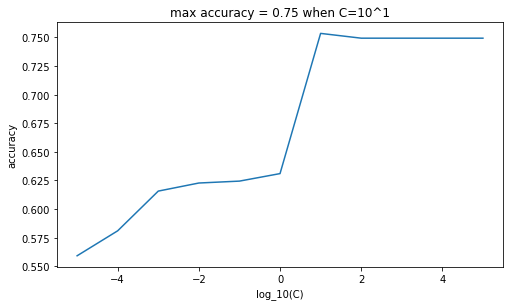

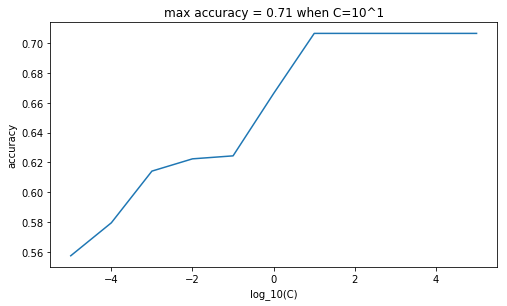

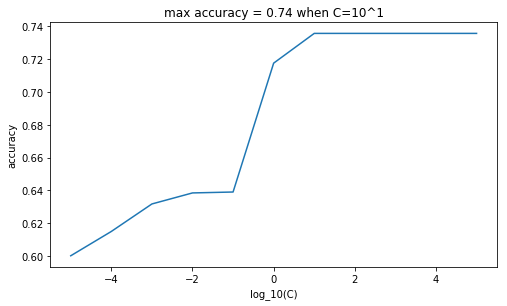

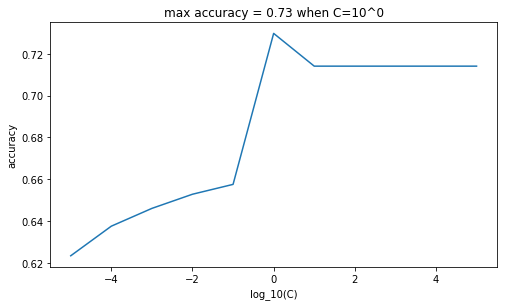

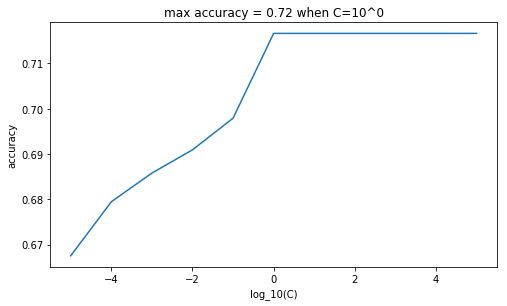

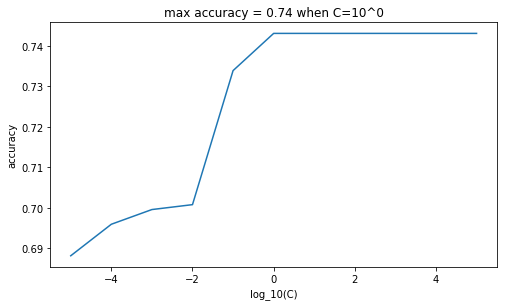

In [108]:
# repeat cross-validation for a wide range of C
from sklearn.model_selection import cross_val_score

#Cs = 10**np.linspace(-20,20,41)
Cs = 10**np.linspace(-5,5,11)
print(Cs)
np.savetxt("SVM_Cs.txt", Cs, fmt="%.1e")

k = 5

num_channels = (2, 4, 8, 16, 32, 64)
num_chosen_channels = list()

for num_ch in num_channels:
    print("number of channels={}".format(num_ch))
    
    if num_ch is not 64:
        mask = load_channel_mask(subject,num_ch)

        # actuall no of channels may be different
        num_ch_read = sum(mask)
        print("number of chosen channels={}".format(num_ch_read))
            
        num_chosen_channels.append(num_ch_read)
        
        X_train_chosen=apply_mask(X_train, mask)
        X_train_chosen.shape
    else:
        X_train_chosen=X_train
        X_train_chosen.shape
            


    accuracy = list()
    for C in tqdm(Cs):
        # model: linear SVM 
#         clf = Pipeline([
#             ("scaler", StandardScaler()),
#             ("linear_svc", LinearSVC(C=C, loss="hinge",  class_weight='balanced', random_state=42)),
#         ])
        clf = svm.LinearSVC(C=C, loss="hinge", class_weight='balanced', max_iter=5000, random_state=42)
    
        accuracy.append(cross_val_score(clf, X_train_chosen, Y_train, cv=k, n_jobs=-1))
        
#         # save model    
#         joblib.dump(clf, "{}_model_SVM_ch{}_C{:.0f}.model".format(subject,num_ch, np.log10(Cs[maxIdx]))) 
    

        
    # calc mean accuracy
    mean_accuracy = np.mean(accuracy,axis=1)
    #print(mean_accuracy)

    maxIdx=np.argmax(mean_accuracy)
    print("max accuracy = {:.2f} when C=10^{:.0f}".format(mean_accuracy[maxIdx], np.log10(Cs[maxIdx])))

    np.savetxt("{}_training_accuracy_SVM_ch{}.txt".format(subject,num_ch), mean_accuracy, fmt="%.2f")

    

    

    # plot results
    plt.figure(figsize=(8, 4.5))

    plt.plot(np.log10(Cs),mean_accuracy)
    #plt.plot(np.log10(Cs), baseAcc*np.ones_like(Cs), '--')
    plt.xlabel('log_10(C)')
    plt.ylabel('accuracy')

    plt.title("max accuracy = {:.2f} when C=10^{:.0f}".format(mean_accuracy[maxIdx], np.log10(Cs[maxIdx])))
    
    plt.savefig("{}_training_accuracy_SVM_ch{}.pdf".format(subject,num_ch))
    plt.savefig("{}_training_accuracy_SVM_ch{}.png".format(subject,num_ch))


In [52]:


np.savetxt('{}_num_chosen_channels.txt'.format(subject),num_chosen_channels, fmt='%d')


## Combine and plot 

In [76]:
accuracy = list()
num_channels = (2, 4, 8, 16, 32, 64)
for num_ch in num_channels:
    mean_accuracy = np.loadtxt("{}_training_accuracy_SVM_ch{}.txt".format(subject,num_ch))
    accuracy.append(mean_accuracy)

accuracy = np.array(accuracy)
accuracy.shape

(6, 11)

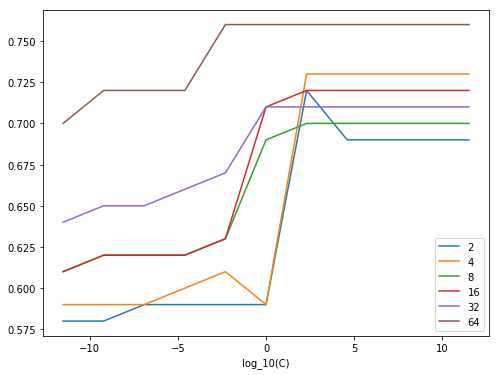

In [77]:
plt.figure(figsize=(8,6))

plt.plot(np.log(Cs), accuracy.transpose())
plt.legend(num_channels)
plt.xlabel('log_10(C)')

plt.savefig("{}_training_accuracy_SVM.pdf".format(subject))
plt.savefig("{}_training_accuracy_SVM.png".format(subject))

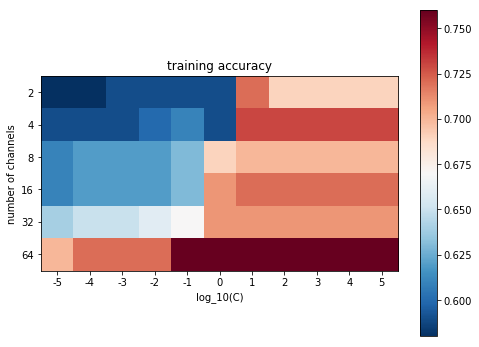

In [78]:

plt.figure(figsize=(8,6))

plt.imshow(accuracy, cmap='RdBu_r',interpolation="none")
plt.colorbar()
plt.xticks(range(len(Cs)), ["{:.0f}".format(np.log10(x)) for x in Cs])
plt.xlabel('log_10(C)')
plt.yticks(range(len(Chs)), ["{:.0f}".format(y) for y in Chs])
plt.ylabel('number of channels')
plt.title('training accuracy')

plt.savefig("{}_training_accuracy_SVM_image.pdf".format(subject))
plt.savefig("{}_training_accuracy_SVM_image.png".format(subject))


    

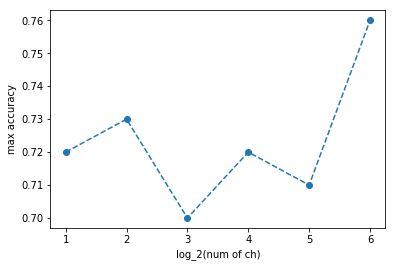

In [79]:
max_accuracy=np.max(accuracy,axis=1)

opt_Cs = Cs[np.argmax(accuracy,axis=1)]
np.savetxt("{}_SVM_opt_Cs.txt".format(subject), opt_Cs, fmt="%.1e")

plt.plot(np.log2(Chs),max_accuracy, 'o--')
plt.xlabel('log_2(num of ch)')
plt.ylabel('max accuracy')

plt.savefig("{}_training_max_accuracy_SVM.pdf".format(subject))
plt.savefig("{}_training_max_accuracy_SVM.png".format(subject))


array([ 10., 100.,  10.,  10.,   1.,   1.])

In [75]:
subject='A'

In [ ]:
subject='AandB'

In [81]:
sum(mask)

19

number of chosen channels=2
number of chosen channels read=[ 1  2  4  8 19 64]
number of chosen channels=4
number of chosen channels read=[ 1  2  4  8 19 64]
number of chosen channels=8
number of chosen channels read=[ 1  2  4  8 19 64]
number of chosen channels=16
number of chosen channels read=[ 1  2  4  8 19 64]
number of chosen channels=32
number of chosen channels read=[ 1  2  4  8 19 64]
number of chosen channels=64


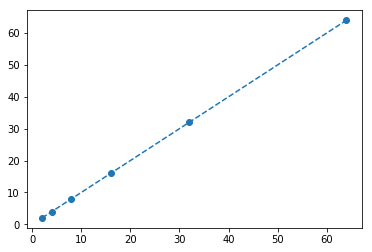

In [102]:
#subject='A'
subject='AandB'

num_channels = (2, 4, 8, 16, 32, 64)

num_chosen_channels = list()
for num_ch in num_channels:
    print("number of chosen channels={}".format(num_ch))
    
    if num_ch is not 64:
        mask = load_channel_mask(subject,num_ch)

        # actuall no of channels may be different
        num_chosen_channels.append(sum(mask))
        
        print("number of chosen channels read={}".format(num_chosen_channels_read))
    else:
        num_chosen_channels.append(num_ch)
        
#num_chosen_channels = np.array(num_chosen_channels)

np.savetxt('{}_num_chosen_channels.txt'.format(subject),num_chosen_channels, fmt='%d')


        
plt.plot(num_channels, num_chosen_channels, 'o--')            

## Joint training

In [35]:
# load data
num_epoches = 85

X_train_A, Y_train_A, C_train_A = load_data('A', 'train', num_epoches)
X_train_B, Y_train_B, C_train_B = load_data('B', 'train', num_epoches)

loaded:
(85, 180, 896)
(85, 180, 1)
(85, 180, 1)
stacked:
(15300, 896)
(15300,)
(15300,)
loaded:
(85, 180, 896)
(85, 180, 1)
(85, 180, 1)
stacked:
(15300, 896)
(15300,)
(15300,)


In [46]:
# combine
X_train = np.vstack((X_train_A,X_train_B))
print(X_train.shape)
Y_train = np.concatenate((Y_train_A, Y_train_B))
print(Y_train.shape)

(30600, 896)
(30600,)


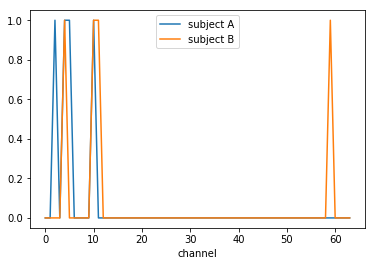

In [37]:
#num_chosen_channels=2
num_chosen_channels=4
mask_A = load_channel_mask('A',num_chosen_channels)
mask_B = load_channel_mask('B',num_chosen_channels)

plt.plot(mask_A)
plt.plot(mask_B)
plt.xlabel('channel')
plt.legend(('subject A','subject B'))
#print(mask)

In [38]:
# combine mask by AND
subject='AandB'
#Chs = (2, 4, 8, 16, 32, 64)
Chs = (2, 4, 8, 16, 32)
for num_chosen_channels in Chs:
    mask_A = load_channel_mask('A',num_chosen_channels)
    mask_B = load_channel_mask('B',num_chosen_channels)

    mask_AB = mask_A*mask_B
    np.savetxt('mask/{}_chosen_channel_mask_{}.txt'.format(subject,num_chosen_channels), mask_AB, fmt="%d")
        
            

In [ ]:
# run the cross validation block



In [28]:
# combine mask by OR
subject='AorB'
#Chs = (2, 4, 8, 16, 32, 64)
Chs = (2, 4, 8, 16, 32)
for num_chosen_channels in Chs:
    mask_A = load_channel_mask('A',num_chosen_channels)
    mask_B = load_channel_mask('B',num_chosen_channels)
    
    mask_AB = 1-(1-mask_A)*(1-mask_B)
    np.savetxt('mask/{}_chosen_channel_mask_{}.txt'.format(subject,num_chosen_channels), mask_AB, fmt="%d")

In [ ]:
# run the cross validation block



In [29]:
subject

'AorB'

## Load test data

**below is old code from https://github.com/ys7yoo/human-plus/blob/master/classifyUsingSVM.ipynb**


## Adding `balancing` 


In [ ]:
# repeat for a wide range of C
Cs = 10**np.linspace(-20,20,41)
Cs

k = 5
scores = list()
for C in Cs:
    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=C, loss="hinge",  class_weight='balanced', random_state=42)),  # balanced!
    ])

    scores.append(cross_val_score(clf, X, Y, cv=k))
    
#scores

mean_scores_balanced = np.mean(scores,axis=1)
#print(mean_scores_balanced)

maxIdx=np.argmax(mean_scores_balanced)
print("max accuracy = {} when C={}".format(mean_scores_balanced[maxIdx], Cs[maxIdx]))




import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(np.log10(Cs),mean_scores)
plt.plot(np.log10(Cs),mean_scores_balanced)
plt.plot(np.log10(Cs), baseAcc*np.ones_like(Cs), '--')
plt.legend(('equal weight','balanced', 'baseline'))
plt.xlabel('log_10(C)')
plt.ylabel('accuracy')
    

In [ ]:
# let's repeat & check confusion matrix!

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("linear_svc", LinearSVC(C=10, loss="hinge", random_state=42)),  # balanced!
    #("linear_svc", LinearSVC(C=10, loss="hinge",  class_weight='balanced', random_state=42)),  # balanced!
])
    

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix

split = StratifiedShuffleSplit(n_splits=5, test_size=1/5, random_state=42)

k = 0

acc_train = list()
acc_test = list()
for train_index, test_index in split.split(X,Y):
#    print(train_index)
#    print(test_index)
    if k==0:   # print info
        print("In the training set of size{},".format(Y[train_index].shape))
        print("cor: {}, incor: {}".format(sum(Y[train_index]==1),sum(Y[train_index]==-1)))
        print("In the training set of size{},".format(Y[test_index].shape))    
        print("cor: {}, incor: {}".format(sum(Y[test_index]==1),sum(Y[test_index]==-1)))
        baseAcc = sum(Y[test_index]==1) / (sum(Y[test_index]==1)+sum(Y[test_index]==-1)) 
        print("base accuracy = {}".format(baseAcc))

    X_train = X[train_index,:]
    Y_train = Y[train_index]
    X_test = X[test_index,:]    
    Y_test = Y[test_index]
    
    clf.fit(X_train,Y_train)

    # training error
    Yhat_train = clf.predict(X_train)
    acc_train.append(np.mean(Yhat_train==Y_train))

    # test error
    Yhat_test = clf.predict(X_test)
    acc_test.append(np.mean(Yhat_test==Y_test))
 
    cm = confusion_matrix(Y_test, Yhat_test, labels=(1,-1))
    print(cm)

#     # let's manually check
#     print(sum((Y_test == 1) & (Yhat_test == 1)))    # 1s are (correctly) predicted as 1s
#     print(sum((Y_test == 1) & (Yhat_test == -1)))   # 1s are predicted as -1
#     print(sum((Y_test == -1) & (Yhat_test == 1)))   # -1s are predicted as 1
#     print(sum((Y_test == -1) & (Yhat_test == -1)))  # -1s are (correctly) predicted as -1

    
    k = k + 1
print("training accuracy")    
print(acc_train)
print("test accuracy")    
print(acc_test)
print(np.mean(acc_test))

In [ ]:
# re-train using all the data (CAN I DO THIS?)

clf.fit(X,Y)

# get coefficient of SVM
w = clf.named_steps['linear_svc'].coef_
w = w.ravel()
#w.shape
plt.plot(w)
plt.ylabel('w')
plt.xlabel('feature index')


w.shape
#listSelectedFeature.shape
listSelectedFeature[w>0.1,:]

listSelectedFeature[w<-0.1,:]


## So, conclusions are
* linear SVM does *NOT* work for p<0.05
* linear SVM does workf for p<0.1

## Nonlinear SVMs

In [ ]:
from sklearn.pipeline import Pipeline

rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", svm.SVC(kernel="rbf", gamma=2, C=10,random_state=42))   # class_weight='balanced',
    ])
    
rbf_kernel_svm_clf.fit(X, Y)

Yhat=rbf_kernel_svm_clf.predict(X)
print(np.mean(Y==Yhat))
plt.plot(Yhat)

## Cross validation with nonlinear SVM

In [ ]:
# repeat for a wide range of gamma and C

Gs=2**np.linspace(-7,3,11)
Gs
Cs = 10**np.linspace(-20,20,41)
Cs


# unbalanced 
k = 5
gs = list()
cs = list()
scores = list()
for G in Gs:
    print("gamma={}".format(G))
    for C in Cs:
        rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", svm.SVC(kernel="rbf", gamma=G, C=C,random_state=42))   # class_weight='balanced',
        ])
        gs.append(G)
        cs.append(C)
        scores.append(cross_val_score(rbf_kernel_svm_clf, X, Y, cv=k))


mean_scores = np.mean(scores,axis=1)
#print(mean_scores)    


maxIdx=np.argmax(mean_scores)
print("max accuracy = {} when gamma={} and C={}".format(mean_scores[maxIdx], gs[maxIdx], cs[maxIdx]))




# save results to files
np.savetxt("gamma.txt", gs)
np.savetxt("C.txt", Cs)
np.savetxt("scores.txt", scores)
np.savetxt("mean_scores.txt", mean_scores)


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(mean_scores)
#plt.plot(np.log10(Cs), mean_scores)
plt.plot(baseAcc*np.ones_like(mean_scores), '--')
plt.xlabel('(gamma,C)')
plt.ylabel('accuracy')

In [ ]:
0.8905555555555555*9

## add balance

In [ ]:
## add balance

Gs=2**np.linspace(-7,3,11)
Gs
Cs = 10**np.linspace(-20,20,41)
Cs


# unbalanced 
k = 5
gs = list()
cs = list()
scores_balanced = list()
for G in Gs:
    print("gamma={}".format(G))
    for C in Cs:
        rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", svm.SVC(kernel="rbf", gamma=G, C=C, class_weight='balanced', random_state=42))   # ,
        ])
        gs.append(G)
        cs.append(C)
        scores_balanced.append(cross_val_score(rbf_kernel_svm_clf, X, Y, cv=k))


mean_scores_balanced = np.mean(scores_balanced,axis=1)
#print(mean_scores)    


maxIdx=np.argmax(mean_scores_balanced)
print("max accuracy = {} when gamma={} and C={}".format(mean_scores_balanced[maxIdx], gs[maxIdx], cs[maxIdx]))




# save results to files
np.savetxt("gamma_balanced.txt", gs)
np.savetxt("C_balanced.txt", Cs)
np.savetxt("scores_balanced.txt", scores_balanced)
np.savetxt("mean_scores_balanced.txt", mean_scores_balanced)


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(mean_scores)
#plt.plot(np.log10(Cs), mean_scores)
plt.plot(baseAcc*np.ones_like(mean_scores), '--')
plt.xlabel('(gamma,C)')
plt.ylabel('accuracy')

In [ ]:
# refit using the best param
rbf_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", svm.SVC(kernel="rbf", gamma=0.03125, C=1, class_weight='balanced', random_state=42))   # ,
])

rbf_kernel_svm_clf.fit(X,Y)

# training error = 0
Yhat = rbf_kernel_svm_clf.predict(X)
np.mean(Yhat==Y)

In [ ]:
# let's repeat & check confusion matrix!

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix

split = StratifiedShuffleSplit(n_splits=5, test_size=1/5, random_state=42)

k = 0

acc_train = list()
acc_test = list()
for train_index, test_index in split.split(X,Y):
#    print(train_index)
#    print(test_index)
    if k==0:   # print info
        print("In the training set of size{},".format(Y[train_index].shape))
        print("cor: {}, incor: {}".format(sum(Y[train_index]==1),sum(Y[train_index]==-1)))
        print("In the training set of size{},".format(Y[test_index].shape))    
        print("cor: {}, incor: {}".format(sum(Y[test_index]==1),sum(Y[test_index]==-1)))
        baseAcc = sum(Y[test_index]==1) / (sum(Y[test_index]==1)+sum(Y[test_index]==-1)) 
        print("base accuracy = {}".format(baseAcc))

    X_train = X[train_index,:]
    Y_train = Y[train_index]
    X_test = X[test_index,:]    
    Y_test = Y[test_index]
    
    rbf_kernel_svm_clf.fit(X_train,Y_train)

    # training error
    Yhat_train = rbf_kernel_svm_clf.predict(X_train)
    acc_train.append(np.mean(Yhat_train==Y_train))

    # test error
    Yhat_test = rbf_kernel_svm_clf.predict(X_test)
    acc_test.append(np.mean(Yhat_test==Y_test))
 
    cm = confusion_matrix(Y_test, Yhat_test, labels=(1,-1))
    print(cm)

#     # let's manually check
#     print(sum((Y_test == 1) & (Yhat_test == 1)))    # 1s are (correctly) predicted as 1s
#     print(sum((Y_test == 1) & (Yhat_test == -1)))   # 1s are predicted as -1
#     print(sum((Y_test == -1) & (Yhat_test == 1)))   # -1s are predicted as 1
#     print(sum((Y_test == -1) & (Yhat_test == -1)))  # -1s are (correctly) predicted as -1

    
    k = k + 1
print("training accuracy")    
print(acc_train)
print("test accuracy")    
print(acc_test)
print(np.mean(acc_test))
print(np.std(acc_test))

In [ ]:
Yhat_test

In [ ]:
8/9